### TEST for 2 Atoms -> influence of angle to V and $\Gamma$

In [28]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation

In [68]:
########################################                 Define constants                   #############################################
N = 2
fixed_lam   = 1
k_a = 2 * np.pi / fixed_lam
fixed_gamma = 1

fixed_dist  = 0.235 * fixed_lam
fixed_phi   = np.pi/2

x_0      = 0.02
x_max    = 1.4
x_size = 200

phi_0    = 0
phi_max  = np.pi / 2
phi_size = 4

t_max    = 40
t_size   = 100
########################################################################################################################    
times  = np.linspace(0, t_max, t_size) * fixed_gamma
dists  = np.linspace(x_0, x_max, x_size) * fixed_lam
phis   = np.linspace(phi_0, phi_max, phi_size)

In [69]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = fixed_phi):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole

def chain_positions(distance = fixed_dist, N = N):
    Pos = np.zeros((N, 3))
    for i in range(N):
        Pos[i,0] = i * distance
    return Pos

In [70]:
########################################             create the Hamiltonean                 #################################################
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance, dipoles, lam, gamma):
    positions = chain_positions(distance)
    G_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            G_matrix[a, b] = gamma
            r_a, r_b = positions[a], positions[b]
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                result = (6 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
                G_matrix[a, b] = np.imag(result)
    return G_matrix

def V_matrix(distance, dipoles, lam, gamma):
    positions = chain_positions(distance, N)
    V_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                result = (3 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
                V_matrix[a, b] = np.real(result)
    return V_matrix
    
def H_eff(distance = fixed_dist, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma):
    G = Gamma_matrix(distance, dipoles, lam, gamma)
    V = V_matrix(distance, dipoles, lam, gamma)
    return Qobj(V) - 1j / 2 * Qobj(G)

In [71]:
Gamma_vals = np.zeros((x_size, phi_size))
V_vals = np.zeros((x_size, phi_size))

for i, dist in enumerate(dists):
    for j, phi in enumerate(phis):
        dipoles = [dipole_vector(phi) for _ in range(N)]
        G = Gamma_matrix(dist, dipoles, fixed_lam, fixed_gamma)
        V = V_matrix(dist, dipoles, fixed_lam, fixed_gamma)
        Gamma_vals[i, j] = G[0, 1]
        V_vals[i, j] = V[0, 1]

C:\Users\leopo\AppData\Local\Temp\ipykernel_19420\994200127.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  Gamma_vals[i, j] = G[0, 1]
C:\Users\leopo\AppData\Local\Temp\ipykernel_19420\994200127.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  V_vals[i, j] = V[0, 1]


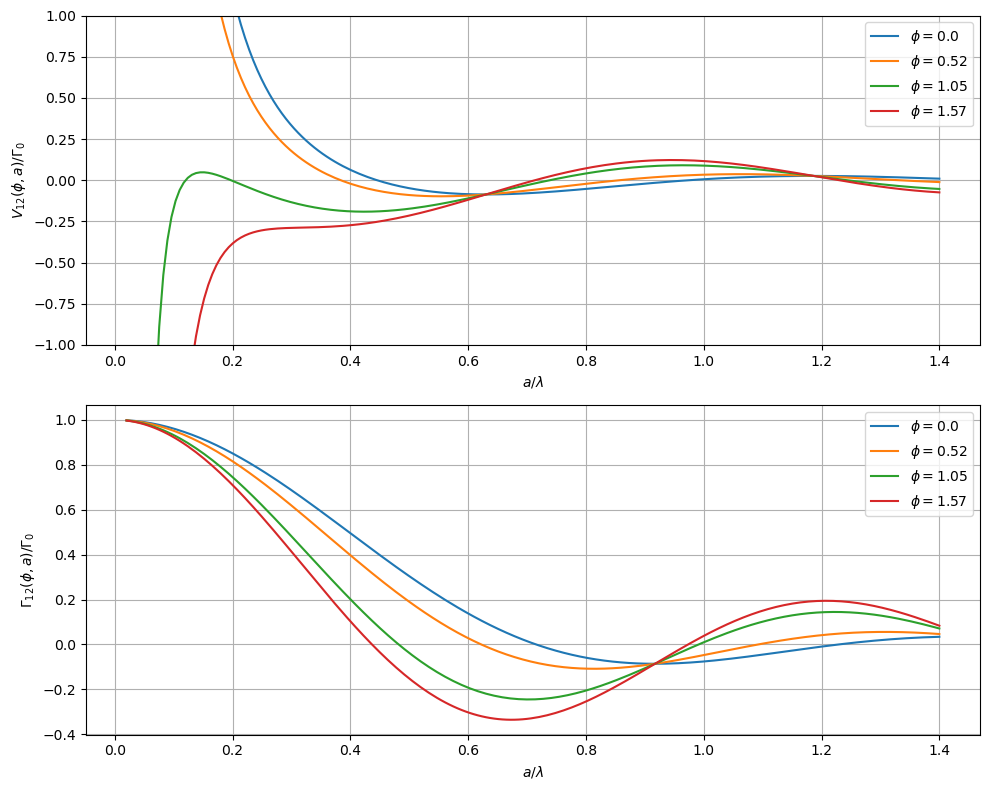

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for j in range(phi_size):
    ax1.plot(dists / fixed_lam, V_vals[:, j] / fixed_gamma, label=f'$\\phi = {round(phis[j], 2)}$')
    ax2.plot(dists / fixed_lam, Gamma_vals[:, j] / fixed_gamma, label=f'$\\phi = {round(phis[j], 2)}$')

ax1.set_xlabel('$a/\\lambda$')
ax1.set_ylabel('$V_{12}(\\phi, a) / \Gamma_0$')
ax1.set_ylim([-1, 1])  # Limit y-axis
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('$a/\\lambda$')
ax2.set_ylabel('$\Gamma_{12}(\\phi, a) / \Gamma_0$')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


C:\Users\leopo\AppData\Local\Temp\ipykernel_19420\3303914927.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  Gamma_vals[i, j] = G[0, 1]  # Store interaction of first two atoms for simplicity
C:\Users\leopo\AppData\Local\Temp\ipykernel_19420\3303914927.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  V_vals[i, j] = V[0, 1]  # Store interaction of first two atoms for simplicity


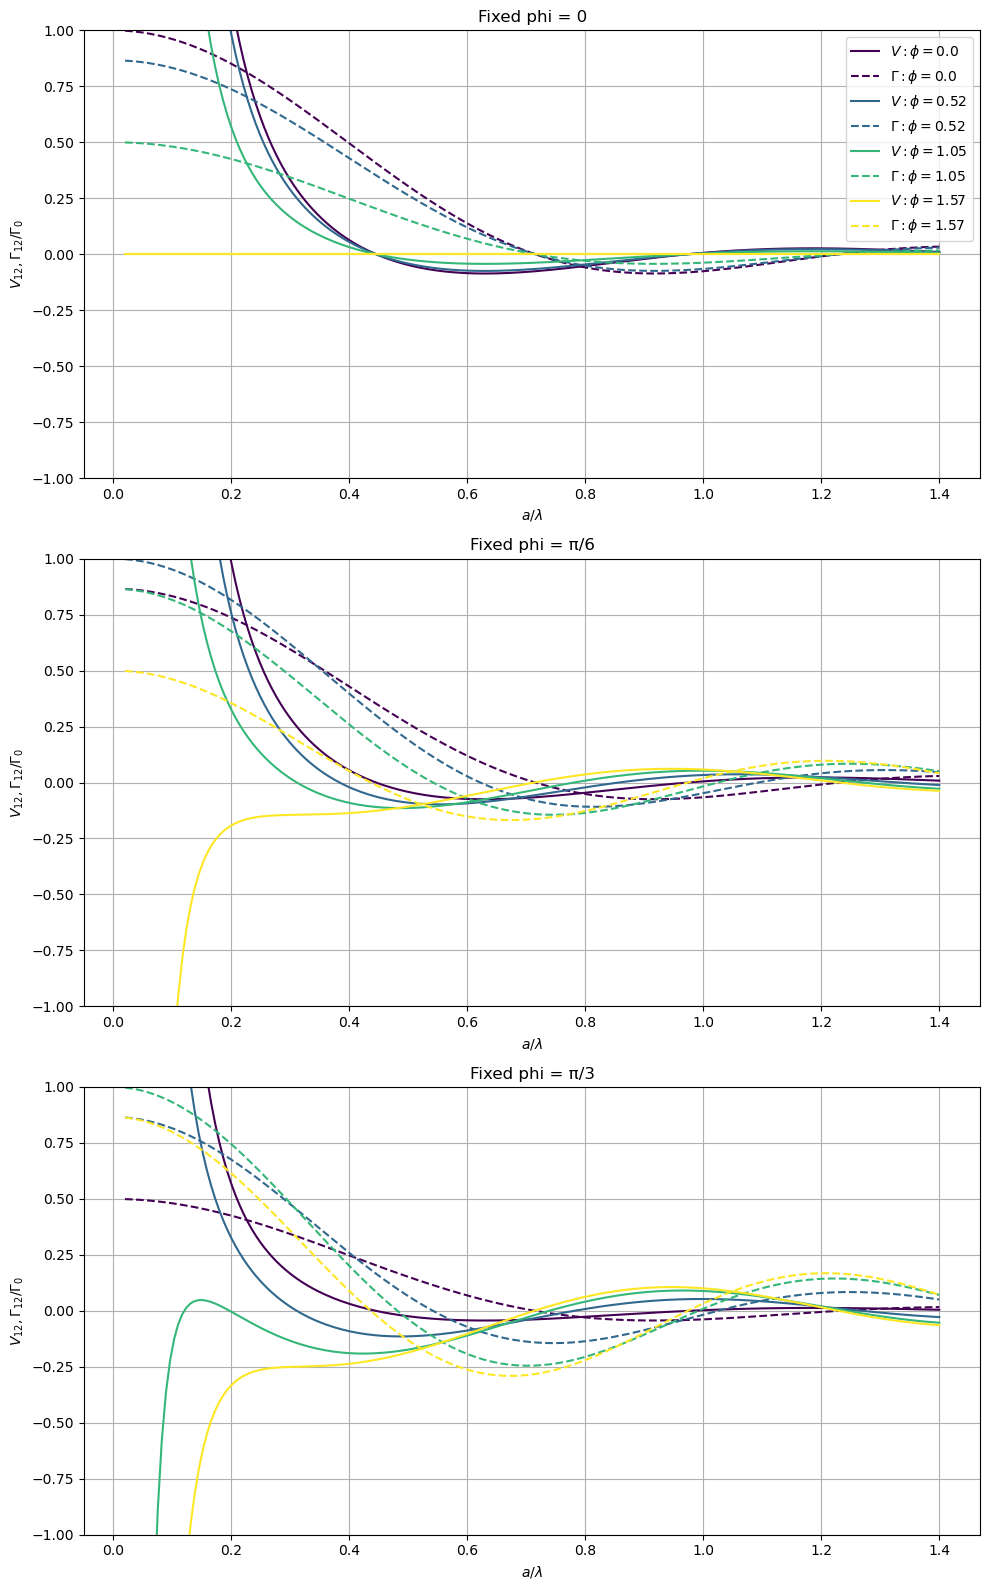

In [73]:
# Define fixed phi values for each plot
fixed_phis = [0, np.pi/6, np.pi/3]
titles = ['Fixed phi = 0', 'Fixed phi = π/6', 'Fixed phi = π/3']

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 16))

# Define a color map for the plots
colors = plt.cm.viridis(np.linspace(0, 1, phi_size))

for idx, fixed_phi in enumerate(fixed_phis):
    Gamma_vals = np.zeros((x_size, phi_size))
    V_vals = np.zeros((x_size, phi_size))

    # Iterate over distances and varying phi angles
    for i, dist in enumerate(dists):
        for j, phi in enumerate(phis):
            dipoles = [dipole_vector(fixed_phi)] + [dipole_vector(phi) for _ in range(1, N)]  # First dipole fixed, rest vary
            G = Gamma_matrix(dist, dipoles, fixed_lam, fixed_gamma)
            V = V_matrix(dist, dipoles, fixed_lam, fixed_gamma)
            Gamma_vals[i, j] = G[0, 1]  # Store interaction of first two atoms for simplicity
            V_vals[i, j] = V[0, 1]  # Store interaction of first two atoms for simplicity

    ax = axes[idx]
    for j in range(phi_size):
        color = colors[j]
        ax.plot(dists / fixed_lam, V_vals[:, j] / fixed_gamma, color=color, label=f'$V: \\phi = {round(phis[j], 2)}$')
        ax.plot(dists / fixed_lam, Gamma_vals[:, j] / fixed_gamma, '--', color=color, label=f'$\\Gamma: \\phi = {round(phis[j], 2)}$')

    ax.set_xlabel('$a/\\lambda$')
    ax.set_ylabel('$V_{12}, \\Gamma_{12} / \Gamma_0$')
    ax.set_ylim([-1, 1])  # Limit y-axis
    ax.set_title(titles[idx])
    ax.grid(True)

# Add legends to the first subplot
handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[0].legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()
plt.show()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.        -0.5j        -0.74192603-0.41530887j]
 [-0.74192603-0.41530887j  0.        -0.5j       ]]


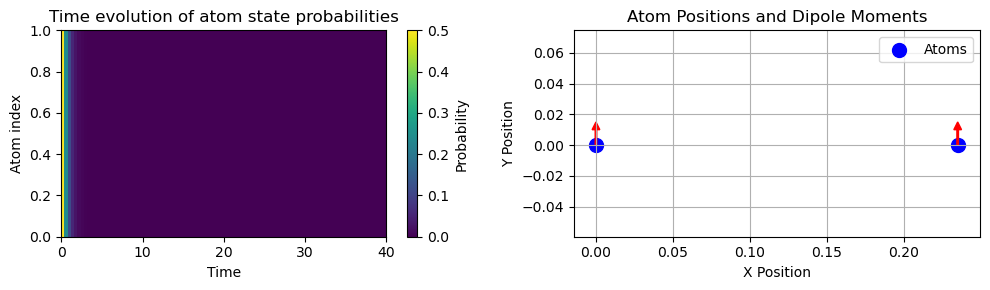

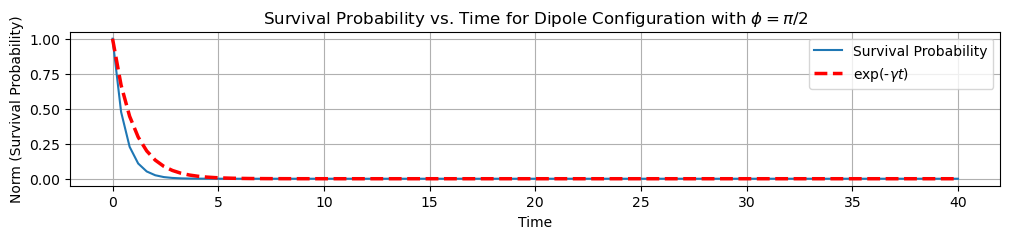

In [81]:
def survival_probabilities(dipoles, times, distance=fixed_dist, gamma=fixed_gamma, Psi_0=basis(N, 0)):
    H = H_eff(distance=distance, dipoles=dipoles, lam=fixed_lam, gamma=gamma)
    print(H)
    coeffs_sq_mods = np.zeros((len(times), N))
    P_surs = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2

        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()

    return coeffs_sq_mods, P_surs

# Define the dipoles for both atoms having phi = pi/2
dipoles = [dipole_vector(np.pi / 2) for _ in range(N)]

# Calculate survival probabilities
psi0 = (basis(N, 0) + basis(N,1)).unit()
distance = 0.15 * fixed_lam
y1, y2 = survival_probabilities(dipoles, times, distance=distance, Psi_0=psi0)
positions = chain_positions(fixed_dist, N)

#
# TODO implement this everywhere
#
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
# Plot the evolution of atom state probabilities
im = ax1.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
ax1.set_xlabel('Time')
ax1.set_ylabel('Atom index')
ax1.set_title('Time evolution of atom state probabilities')
fig.colorbar(im, ax=ax1, label='Probability')

# Plot atoms with their dipole moments
ax2.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    ax2.arrow(positions[i, 0], positions[i, 1], dipoles[i][0] * 0.01, dipoles[i][1] * 0.01, head_width=0.5 * 0.01, head_length=0.5 * 0.01, fc='red', ec='red')
ax2.set_title('Atom Positions and Dipole Moments')
ax2.set_xlabel('X Position')
ax2.set_ylabel('Y Position')
ax2.grid(True)
ax2.legend()
ax2.axis('equal')

plt.tight_layout()
plt.show()

# Plot the norms against time
plt.figure(figsize=(12, 2))
plt.plot(times, y2, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time') 
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Dipole Configuration with $\phi = \pi/2$')
plt.legend()
plt.grid(True)
plt.show()